In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
from monte_carlo_utils import make_bins, get_bin, place_into_bins

In [2]:
input_directory = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
)

input_file = input_directory/'oil_attribution.yaml'

### open oil_attrs yaml file for 
with open(input_file) as file:
    oil_attrs = yaml.load(file, Loader=yaml.Loader)

### load ATB data
atb_data_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='atb data', 
    usecols='A,B,C,D,E'
)    
    
# Get Total number of AIS pings and vessel length by MMSI for
# our different ship types
data = {}
data['count'] = {}
data['length'] = {}
length_bins = {}
for vessel in oil_attrs['categories']['all_vessels']:
    input_data = pandas.read_excel(
        oil_attrs['files']['oil_capacity'],
        sheet_name=f'{vessel} data', 
        usecols='B,C'
    )
    data['count'][vessel]  = input_data['COUNT']
    data['length'][vessel] = input_data['LENGTH']
    length_bins[vessel] = {}


In [3]:
colors = ['darkslateblue', 'cornflowerblue', 
          'tab:gray', 'tab:olive',
          'rebeccapurple','indianred',
          'maroon','darkgoldenrod',
          'khaki']

# colors = ['darkslateblue', 'steelblue', 
#           'tab:gray', 'tab:olive',
#           'tab:purple','goldenrod',
#           'tab:cyan','cornflowerblue',
#           'rebeccapurple']

# tanker
length_bins['tanker']['lower_bound'] = 0
length_bins['tanker']['upper_bound'] = 300
length_bins['tanker']['step_size']   = 50

# atb
length_bins['atb']['lower_bound'] = 0
length_bins['atb']['upper_bound'] = 300
length_bins['atb']['step_size']   = 25

# barge
length_bins['barge']['lower_bound'] = 0
length_bins['barge']['upper_bound'] = 100
length_bins['barge']['step_size']   = 10

# cargo
length_bins['cargo']['lower_bound'] = 200
length_bins['cargo']['upper_bound'] = 400
length_bins['cargo']['step_size']   = 25

# cruise
length_bins['cruise']['lower_bound'] = 250
length_bins['cruise']['upper_bound'] = 350
length_bins['cruise']['step_size']   = 10

# ferry
length_bins['ferry']['lower_bound'] = 35
length_bins['ferry']['upper_bound'] = 160
length_bins['ferry']['step_size']   = 10

# fishing
length_bins['fishing']['lower_bound'] = 0
length_bins['fishing']['upper_bound'] = 80
length_bins['fishing']['step_size']   = 10

# smallpass
length_bins['smallpass']['lower_bound'] = 0
length_bins['smallpass']['upper_bound'] = 35
length_bins['smallpass']['step_size']   = 5

# other
length_bins['other']['lower_bound'] = 0
length_bins['other']['upper_bound'] = 35
length_bins['other']['step_size']   = 5


### Add all traffic to the same graphic

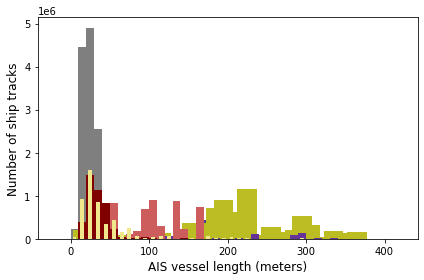

In [4]:
color_index=0

[bins, bin_centers]  = make_bins(
    lower_bound = 0,
    upper_bound = 400,
    step_size   = 10
)

fig = plt.figure()
ax1 = fig.add_subplot(111)
length = len(bin_centers) 

for vessel in oil_attrs['categories']['all_vessels']:
    
    binned_count = place_into_bins(
        data['length'][vessel], 
        data['count'][vessel], 
        bins
    )
    
    step_size = length_bins[vessel]['step_size']
    ax1.bar(
        bin_centers,
        binned_count,
        label=vessel,
        width=step_size,
        color=colors[color_index]
    )
    
    color_index += 1

plt.xlabel('AIS vessel length (meters)',fontsize=12)
plt.ylabel('Number of ship tracks',fontsize=12)
plt.tight_layout()
plt.show() 
ax1.legend()

### Scale ATB by time interval to see if/how it affects result
I still need to check that the result that all are scaling down is a good result and not a reflection that I made a mistake 

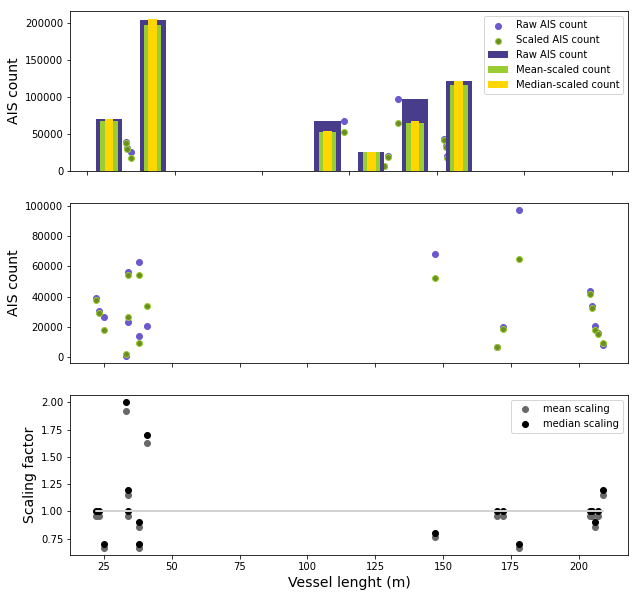

In [5]:
# create bins for both raw and scaled data
[bins, bin_centers]  = make_bins(
    lower_bound = length_bins['atb']['lower_bound'],
    upper_bound = length_bins['atb']['upper_bound'],
    step_size   = length_bins['atb']['step_size']
)

# bin the raw data first
binned_count = place_into_bins(
    data['length']['atb'], 
    data['count']['atb'], 
    bins
)

atb_bin_centers = bin_centers
atb_binned_count = binned_count

# scale tracks according to time interval between pings
scaling_factor = (atb_data_df['Median time between pings (minutes)']/
                  numpy.mean(atb_data_df['Median time between pings (minutes)'])
                 )
scaling_factor_median = (atb_data_df['Median time between pings (minutes)']/
                  numpy.median(atb_data_df['Median time between pings (minutes)'])
                 )
    
atb_tracks = (atb_data_df['COUNT'] * scaling_factor)
atb_tracks_median = (atb_data_df['COUNT'] * scaling_factor_median)

# place scaled tracks into length bins
binned_tracks = place_into_bins(
    atb_data_df['LENGTH'], 
    atb_tracks, 
    bins
)

binned_tracks_median = place_into_bins(
    atb_data_df['LENGTH'], 
    atb_tracks_median, 
    bins
)

fs = 14
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.bar(
    atb_bin_centers,
    atb_binned_count,
    width=15,
    label='Raw AIS count',
    color='darkslateblue'
)
ax1.bar(
    bin_centers,
    binned_tracks,
    width=10,
    label='Mean-scaled count',
    color='yellowgreen'
)
ax1.bar(
    bin_centers,
    binned_tracks_median,
    width=5,
    label='Median-scaled count',
    color='gold'
)
# scatter of raw data
ax1.scatter(
    data['length']['atb'],
    data['count']['atb'],
    label='Raw AIS count',
    color='slateblue'
)
# scatter of scaled data
ax1.scatter(
    data['length']['atb'],
    atb_tracks,
    label='Scaled AIS count',
    color='olivedrab',
    edgecolor='yellowgreen'
)
#  Add scatter to second graphis to see it better
# scatter of raw data
ax2.scatter(
    data['length']['atb'],
    data['count']['atb'],
    label='Raw AIS count',
    color='slateblue'
)
# scatter of scaled data
ax2.scatter(
    data['length']['atb'],
    atb_tracks,
    label='Scaled AIS count',
    color='olivedrab',
    edgecolor='yellowgreen'
)

# plot the scaling factor
# scatter of scaled data
ax3.scatter(
    data['length']['atb'],
    scaling_factor,
    color='dimgrey',
    label='mean scaling'
)
ax3.scatter(
    data['length']['atb'],
    scaling_factor_median,
    color='black',
    label='median scaling'
)
ax3.plot(
    data['length']['atb'],
    numpy.ones(len(data['length']['atb'])),
    color='lightgrey'
)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.set_xticklabels('')
ax1.set_ylabel('AIS count', fontsize=fs)
ax1.legend()

ax2.set_ylabel('AIS count', fontsize=fs)
ax2.set_xticklabels('')

ax3.set_ylabel('Scaling factor', fontsize=fs)
ax3.set_xlabel('Vessel lenght (m)', fontsize=fs)
ax3.legend()
plt.show()

In [6]:
test = atb_data_df['Median time between pings (minutes)']/numpy.mean(atb_data_df['Median time between pings (minutes)'])
test                        

0     0.861702
1     0.957447
2     1.627660
3     0.957447
4     0.670213
5     0.957447
6     0.957447
7     1.148936
8     0.957447
9     1.914894
10    1.148936
11    0.957447
12    0.765957
13    0.861702
14    0.670213
15    0.670213
16    0.957447
17    0.957447
Name: Median time between pings (minutes), dtype: float64

### Show AIS pings multiplied by oil capacity

In [7]:
from get_oil_capacity import get_oil_capacity

random_seed=None
# Initialize PCG-64 random number generator
random_generator = numpy.random.default_rng(random_seed)
fuel = {}
cargo={}

# create lengths for calculating oil capacity
[bins, bin_centers]  = make_bins(
    lower_bound = 0,
    upper_bound = 400,
    step_size   = 10
)

# calculate oil capacity by length and vessel type
for vessel in oil_attrs['categories']['all_vessels']:
    for length in bin_centers:
        [fuel_output,cargo_output] = get_oil_capacity(
            input_file, 
            length, 
            vessel, 
            random_generator
        )
        
        if vessel not in fuel:
            fuel[vessel]=[fuel_output]
            cargo[vessel]=[cargo_output]
        else:
            fuel[vessel].append(fuel_output)
            cargo[vessel].append(cargo_output)


### Calculated scaled values for AIS count

In [8]:
binned_count = {}
binned_count['raw'] = {}
binned_count['fuel_scaled'] = {}
binned_count['cargo_scaled'] = {}

for vessel in oil_attrs['categories']['all_vessels']:
    
    binned_data = place_into_bins(
        data['length'][vessel], 
        data['count'][vessel], 
        bins
    )
    
    # store values
    binned_count['raw'][vessel] = binned_data
    
    # multiply counts in length bins by oil capacity in bin
    binned_count['fuel_scaled'][vessel] = binned_data * fuel[vessel] 
    binned_count['cargo_scaled'][vessel] = binned_data * cargo[vessel]
    
    # correct barge traffic to reflect 1 oil cargo barge for every ~10 barges. 
    if 'barge' in vessel:
        binned_count['cargo_scaled'][vessel] = binned_data * cargo[vessel]/10

### First plot by fuel oil capacity and length

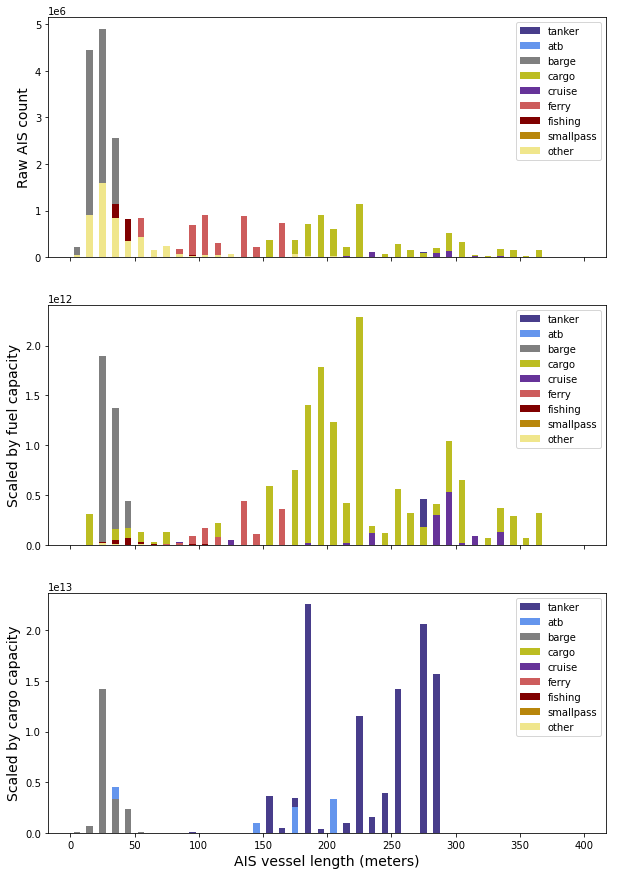

In [9]:
from textwrap import wrap
fs = 14
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

length = len(bin_centers) 
color_index=0
for vessel in oil_attrs['categories']['all_vessels']:
    ax1.bar(
        bin_centers,
        binned_count['raw'][vessel],
        label=vessel,
        width = step_size,
        color=colors[color_index]
    )
    
    ax2.bar(
        bin_centers,
        binned_count['fuel_scaled'][vessel],
        label=vessel,
        width = step_size,
        color=colors[color_index]
    )
    
    ax3.bar(
        bin_centers,
        binned_count['cargo_scaled'][vessel],
        label=vessel,
        width = step_size,
        color=colors[color_index]
    )
    color_index += 1
    
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# Set common labels
# ax.set_xlabel('common xlabel')
# ax.set_ylabel('common ylabel')

# Set specific plot labels
ax1.set_ylabel('Raw AIS count',fontsize=fs)
ax2.set_ylabel('Scaled by fuel capacity',fontsize=fs)
ax3.set_ylabel('Scaled by cargo capacity',fontsize=fs)
ax1.set_xticklabels('')
ax2.set_xticklabels('')

ax3.set_xlabel('AIS vessel length (meters)',fontsize=fs)

ax1.legend()
ax2.legend()
ax3.legend()
# plt.tight_layout()
# plt.show() 
# ax1.legend()


### Plot ship tracks by vessel type and length

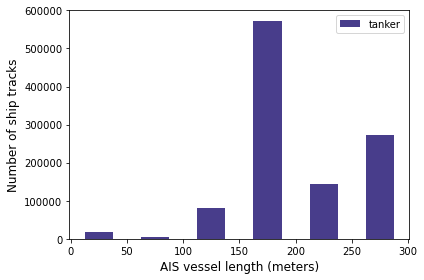

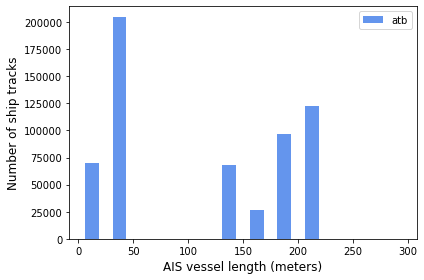

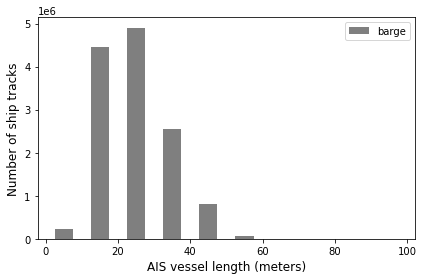

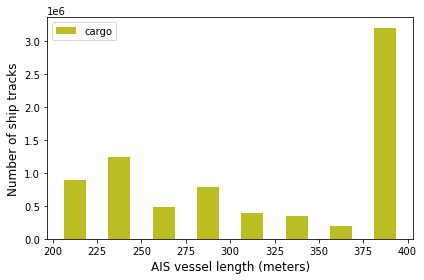

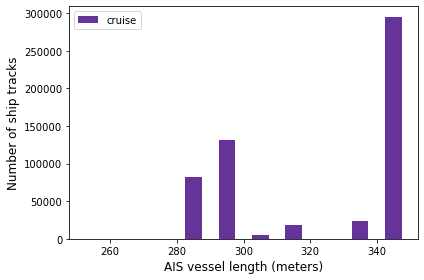

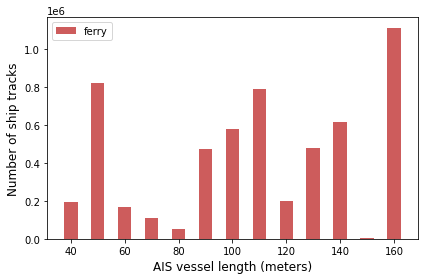

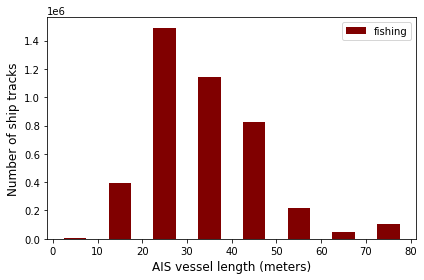

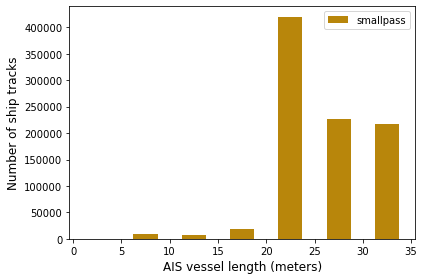

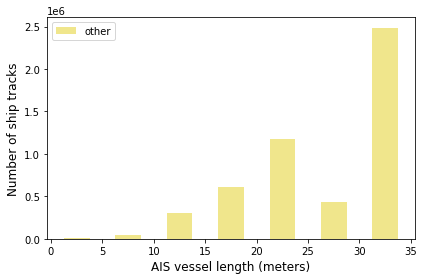

In [10]:
color_index=0
for vessel in oil_attrs['categories']['all_vessels']:

    lower_bound = length_bins[vessel]['lower_bound']
    upper_bound = length_bins[vessel]['upper_bound']
    step_size   = length_bins[vessel]['step_size']

    [bins, bin_centers]  = make_bins(
        lower_bound,
        upper_bound,
        step_size
    )

    binned_count = place_into_bins(
        data['length'][vessel], 
        data['count'][vessel], 
        bins
    )
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.bar(
        bin_centers,
        binned_count,
        label=vessel,
        width = step_size/2,
        color=colors[color_index]
    )
    plt.xlabel('AIS vessel length (meters)',fontsize=12)
    plt.ylabel('Number of ship tracks',fontsize=12)
    plt.tight_layout()
    ax1.legend()
    plt.show() 
    
    color_index += 1

In [11]:
mins = numpy.zeros(len(oil_attrs['categories']['all_vessels']))
maxs = numpy.zeros(len(oil_attrs['categories']['all_vessels']))
i = 0

data['length']['ferry'].replace(numpy.nan,0)
for vessel in oil_attrs['categories']['all_vessels']:
    if vessel == 'ferry':
        not_nan = ~numpy.isnan(data["length"]['ferry'])
        real_ferry = data["length"]['ferry'][not_nan]
        print(f'{vessel}[ min: {min(real_ferry)}, max: {max(real_ferry)}]')
        mins[i] = min(real_ferry)
        maxs[i] = max(real_ferry)
    else:
        print(f'{vessel}[ min: {min(data["length"][vessel])}, max: {max(data["length"][vessel])}]')
        mins[i] = min(data["length"][vessel])
        maxs[i] = max(data["length"][vessel])
    i+=1
    

tanker[ min: 42, max: 287]
atb[ min: 22, max: 209]
barge[ min: 0, max: 100]
cargo[ min: 0, max: 369]
cruise[ min: 60, max: 334]
ferry[ min: 26.0, max: 168.0]
fishing[ min: 0, max: 200]
smallpass[ min: 0, max: 75]
other[ min: 0, max: 620]


In [12]:
# take a look at oil capacity and fuel capacity values

oil_attribution_dir  = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data'
)
oil_attribution_file = oil_attribution_dir/'oil_attribution.yaml'

min_fuel_capacity = numpy.zeros(len(mins))
max_fuel_capacity = numpy.zeros(len(mins))
min_cargo_capacity = numpy.zeros(len(mins))
max_cargo_capacity = numpy.zeros(len(mins))

for i in range(len(mins)):

    min_vessel_len, max_vessel_len, vessel_type = mins[i], maxs[i], oil_attrs['categories']['all_vessels'][i]
    min_fuel_capacity[i], min_cargo_capacity[i] = get_oil_capacity(
            oil_attribution_file, min_vessel_len, vessel_type, random_generator
        )
    max_fuel_capacity[i], max_cargo_capacity[i] = get_oil_capacity(
            oil_attribution_file, max_vessel_len, vessel_type, random_generator
        )

### compare calculated fuel capacities with limits

In [13]:
min_fuel_boundary  = []
max_fuel_boundary  = []
min_cargo_boundary = []
max_cargo_boundary = []
for vessel in oil_attrs['categories']['all_vessels']:
    min_fuel_boundary.append(oil_attrs['vessel_attributes'][vessel]['min_fuel'])
    max_fuel_boundary.append(oil_attrs['vessel_attributes'][vessel]['max_fuel'])
    if vessel in oil_attrs['categories']['tank_vessels']:
        min_cargo_boundary.append(oil_attrs['vessel_attributes'][vessel]['min_cargo'])
        max_cargo_boundary.append(oil_attrs['vessel_attributes'][vessel]['max_cargo'])
    else:
        min_cargo_boundary.append(numpy.NaN)
        max_cargo_boundary.append(numpy.NaN)

In [14]:
len(min_cargo_boundary)

9

In [15]:
data = {'vessel type': oil_attrs['categories']['all_vessels'],
        'min observed length': mins,
        'min get_fuel_capacity'  : min_fuel_capacity,
        'min fuel threshold'     : min_fuel_boundary, 
        'min get_cargo_capacity' : min_cargo_capacity,
        'min cargo threshold'    : min_cargo_boundary,
        'max observed length': maxs,
        'max get_fuel_capacity'  : max_fuel_capacity,
        'max fuel threshold'     : max_fuel_boundary, 
        'max get_cargo_capacity' : max_cargo_capacity,
        'max cargo threshold'    : max_cargo_boundary, 
       }
df = pandas.DataFrame (data, columns = list(data.keys()))
df

,vessel type,min observed length,min get_fuel_capacity,min fuel threshold,min get_cargo_capacity,min cargo threshold,max observed length,max get_fuel_capacity,max fuel threshold,max get_cargo_capacity,max cargo threshold
0,tanker,42.0,740700.0,740700,7593628.0,7593628.0,287.0,4155000.0,4155000,1.854470e+08,185447000.0
1,atb,22.0,387500.0,99000,29000000.0,4000000.0,209.0,87500.0,550000,2.861345e+07,29413150.0
2,barge,0.0,6000.0,6000,1500000.0,1500000.0,100.0,312500.0,710000,1.300000e+07,32000000.0
3,cargo,0.0,1500000.0,1500000,0.0,NaN,369.0,2000000.0,2000000,0.000000e+00,NaN
4,cruise,60.0,1000000.0,1000000,0.0,NaN,334.0,5500000.0,5500000,0.000000e+00,NaN
5,ferry,26.0,30000.0,30000,0.0,NaN,168.0,500000.0,500000,0.000000e+00,NaN
6,fishing,0.0,150.0,150,0.0,NaN,200.0,300000.0,300000,0.000000e+00,NaN
7,smallpass,0.0,100.0,100,0.0,NaN,75.0,12000.0,12000,0.000000e+00,NaN
8,other,0.0,100.0,100,0.0,NaN,620.0,12000.0,12000,0.000000e+00,NaN


In [23]:
### test upper and lower boundaries

for i in range(len(oil_attrs['categories']['all_vessels'])):

    min_fuel_capacity[i], min_cargo_capacity[i] = get_oil_capacity(
            oil_attribution_file, 0.1, oil_attrs['categories']['all_vessels'][i], random_generator
        )
    max_fuel_capacity[i], max_cargo_capacity[i] = get_oil_capacity(
            oil_attribution_file, 10000, oil_attrs['categories']['all_vessels'][i], random_generator
        )
   

In [24]:
data = {'vessel type': oil_attrs['categories']['all_vessels'],
        'min observed length': mins,
        'min get_fuel_capacity'  : min_fuel_capacity,
        'min fuel threshold'     : min_fuel_boundary, 
        'min get_cargo_capacity' : min_cargo_capacity,
        'min cargo threshold'    : min_cargo_boundary,
        'max observed length': maxs,
        'max get_fuel_capacity'  : max_fuel_capacity,
        'max fuel threshold'     : max_fuel_boundary, 
        'max get_cargo_capacity' : max_cargo_capacity,
        'max cargo threshold'    : max_cargo_boundary, 
       }
df = pandas.DataFrame (data, columns = list(data.keys()))
df

,vessel type,min observed length,min get_fuel_capacity,min fuel threshold,min get_cargo_capacity,min cargo threshold,max observed length,max get_fuel_capacity,max fuel threshold,max get_cargo_capacity,max cargo threshold
0,tanker,42.0,740700.0,740700,7593628.0,7593628.0,287.0,4155000.0,4155000,185447000.0,185447000.0
1,atb,22.0,99000.0,99000,4000000.0,4000000.0,209.0,550000.0,550000,29413150.0,29413150.0
2,barge,0.0,6000.0,6000,1500000.0,1500000.0,100.0,710000.0,710000,32000000.0,32000000.0
3,cargo,0.0,1500000.0,1500000,0.0,NaN,369.0,2000000.0,2000000,0.0,NaN
4,cruise,60.0,1000000.0,1000000,0.0,NaN,334.0,5500000.0,5500000,0.0,NaN
5,ferry,26.0,30000.0,30000,0.0,NaN,168.0,500000.0,500000,0.0,NaN
6,fishing,0.0,150.0,150,0.0,NaN,200.0,300000.0,300000,0.0,NaN
7,smallpass,0.0,100.0,100,0.0,NaN,75.0,12000.0,12000,0.0,NaN
8,other,0.0,100.0,100,0.0,NaN,620.0,12000.0,12000,0.0,NaN


In [17]:
# import sys 
# sys.path.append('/usr/lib/python3/dist-packages')
# df.to_excel('fuel_and_cargo_thresholds.xlsx')

In [18]:
# fig, ax = plt.subplots(1)
# ax.plot(
#     oil_attrs['categories']['all_vessels'], 
#     min_fuel_capacity,
#     'b')
# ax.fill_between(
#     oil_attrs['categories']['all_vessels'], 
#     oil_attrs['vessel_attributes'][:]['min_fuel'], 
#     oil_attrs['vessel_attributes'][:]['max_fuel'],
#     facecolor='blue', alpha=0.5)
